/home/klab/anaconda3/envs/iEEG_EHR/lib/python3.14/site-packages/pynwb/misc.py:331: UserWarning: Neither source_timeseries nor source_channels is present in DecompositionSeries. It is recommended to indicate the source timeseries if it is present, or else to link to the corresponding source_channels. (Optional)
  warnings.warn("Neither source_timeseries nor source_channels is present in DecompositionSeries. It is "


✓ Loaded: /mnt/NAS/iEEG_EHR_converted/fft/sub-259/ses-01/ieeg/sub-259_ses-01_run-IA6194BZ_bipolar_psd.nwb

Available processing modules: ['ecephys']

BAND POWER DATA INFO
Data shape: (28799, 214, 6)
Sampling rate: 4.0 Hz

Bands DataFrame:
     band_name    band_limits
id                           
0        delta     [1.0, 4.0]
1        theta     [4.0, 8.0]
2        alpha    [8.0, 12.0]
3         beta   [15.0, 25.0]
4        gamma   [25.0, 70.0]
5   high_gamma  [70.0, 170.0]

Band names: ['delta', 'theta', 'alpha', 'beta', 'gamma', 'high_gamma']
Band limits: [array([1., 4.]), array([4., 8.]), array([ 8., 12.]), array([15., 25.]), array([25., 70.]), array([ 70., 170.])]

Reconstructed BANDS dict:
  delta: (np.float64(1.0), np.float64(4.0))
  theta: (np.float64(4.0), np.float64(8.0))
  alpha: (np.float64(8.0), np.float64(12.0))
  beta: (np.float64(15.0), np.float64(25.0))
  gamma: (np.float64(25.0), np.float64(70.0))
  high_gamma: (np.float64(70.0), np.float64(170.0))

LOADED DATA
Data sh

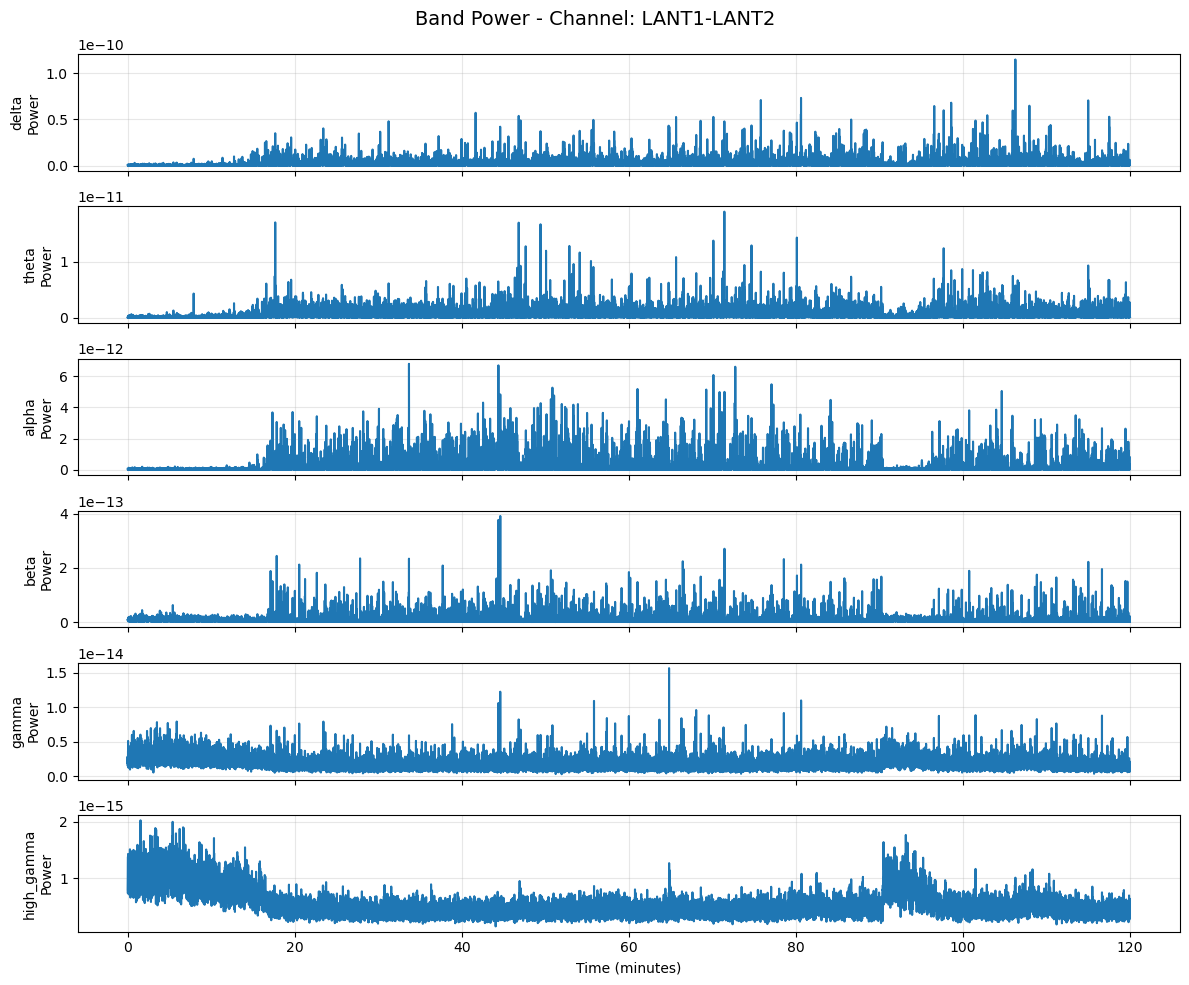

In [5]:
"""
CORRECTED LOADING CODE for your bandpower NWB file

The issue is that DecompositionSeries.bands is a DynamicTable, not a dictionary.
You need to access it differently than your original code.
"""

import pynwb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the processed NWB file
processed_path = '/mnt/NAS/iEEG_EHR_converted/fft/sub-259/ses-01/ieeg/sub-259_ses-01_run-IA6194BZ_bipolar_psd.nwb'
io = pynwb.NWBHDF5IO(processed_path, 'r')
nwb = io.read()
print(f"✓ Loaded: {processed_path}")

print(f"\nAvailable processing modules: {list(nwb.processing.keys())}")

# Get the band power data
ecephys = nwb.processing['ecephys']
band_power = ecephys['band_power']

print(f"\n{'='*70}")
print("BAND POWER DATA INFO")
print('='*70)
print(f"Data shape: {band_power.data.shape}")
print(f"Sampling rate: {band_power.rate} Hz")

# ============================================================================
# CORRECTED WAY TO GET BAND NAMES
# ============================================================================
# The bands are stored as a DynamicTable, not a dict of objects with .band_name
# You need to access it like a DataFrame

bands_df = band_power.bands.to_dataframe()
print(f"\nBands DataFrame:")
print(bands_df)

# Get band names (they're in the 'band_name' column)
band_names = bands_df['band_name'].tolist()
print(f"\nBand names: {band_names}")

# Get band limits (they're in the 'band_limits' column)
band_limits = bands_df['band_limits'].tolist()
print(f"Band limits: {band_limits}")

# ============================================================================
# ALTERNATIVE: If you want to maintain your original structure
# ============================================================================
# Create a dict similar to your BANDS dict
BANDS_LOADED = {}
for idx, row in bands_df.iterrows():
    band_name = row['band_name']
    limits = row['band_limits']
    BANDS_LOADED[band_name] = tuple(limits)

print(f"\nReconstructed BANDS dict:")
for name, limits in BANDS_LOADED.items():
    print(f"  {name}: {limits}")

# ============================================================================
# Get the actual bandpower data
# ============================================================================
bp_data = band_power.data[:]  # Shape: (n_windows, n_channels, n_bands)
print(f"\n{'='*70}")
print("LOADED DATA")
print('='*70)
print(f"Data shape: {bp_data.shape}")
print(f"  n_windows = {bp_data.shape[0]}")
print(f"  n_channels = {bp_data.shape[1]}")
print(f"  n_bands = {bp_data.shape[2]}")

# ============================================================================
# Get electrode information
# ============================================================================
electrodes_df = nwb.electrodes.to_dataframe()
channel_names = electrodes_df['location'].tolist()

print(f"\n{'='*70}")
print("ELECTRODE INFO")
print('='*70)
print(f"Number of channels: {len(channel_names)}")
print(f"First 5 channel names: {channel_names[:5]}")
print(f"Electrode table columns: {electrodes_df.columns.tolist()}")

# ============================================================================
# Calculate time vector
# ============================================================================
n_windows = bp_data.shape[0]
duration = n_windows / band_power.rate  # total duration in seconds
time_sec = np.arange(n_windows) / band_power.rate  # time in seconds
time_min = time_sec / 60  # time in minutes

print(f"\n{'='*70}")
print("TIME INFO")
print('='*70)
print(f"Duration: {duration/60:.1f} minutes")
print(f"Time windows: {n_windows}")
print(f"Sampling rate: {band_power.rate} Hz")
print(f"Time resolution: {1/band_power.rate:.2f} seconds per window")

# ============================================================================
# Example: Plot first channel, all bands
# ============================================================================
print(f"\n{'='*70}")
print("EXAMPLE VISUALIZATION")
print('='*70)

fig, axes = plt.subplots(len(band_names), 1, figsize=(12, 10), sharex=True)
fig.suptitle(f'Band Power - Channel: {channel_names[0]}', fontsize=14)

for i, band_name in enumerate(band_names):
    axes[i].plot(time_min, bp_data[:, 0, i])
    axes[i].set_ylabel(f'{band_name}\nPower')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (minutes)')
plt.tight_layout()
plt.savefig('bandpower_example.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved example plot to 'bandpower_example.png'")

# ============================================================================
# SUMMARY OF THE FIX
# ============================================================================
print(f"\n{'='*70}")
print("SUMMARY OF THE FIX")
print('='*70)
print("\nYour original code:")
print("  ❌ band_names = [band.band_name for band in band_power.bands.values()]")
print("\nCorrected code:")
print("  ✓ bands_df = band_power.bands.to_dataframe()")
print("  ✓ band_names = bands_df['band_name'].tolist()")
print("  ✓ band_limits = bands_df['band_limits'].tolist()")

print("\n✓ Data loaded successfully!")
io.close()

NameError: name 'time' is not defined

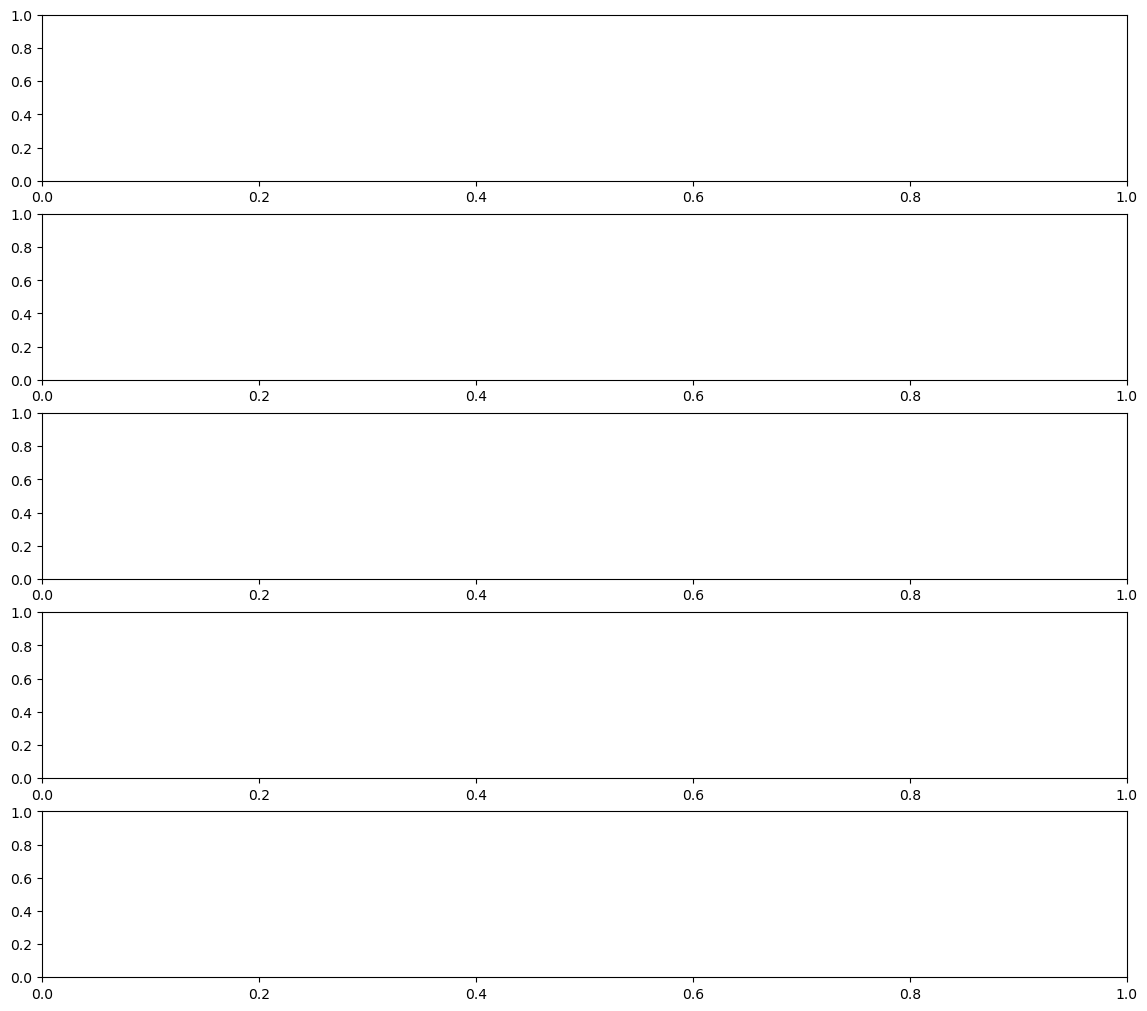

In [6]:
# Select channels to plot
n_channels_to_plot = 5
channels_to_plot = list(range(n_channels_to_plot))  # First 5 channels
# Or select specific channels by name:
# channels_to_plot = [i for i, name in enumerate(channel_names) if 'LANT' in name][:5]

fig, axes = plt.subplots(len(channels_to_plot), 1, figsize=(14, 2.5 * len(channels_to_plot)))

if len(channels_to_plot) == 1:
    axes = [axes]

for idx, ch_idx in enumerate(channels_to_plot):
    ax = axes[idx]
    
    # Plot each frequency band
    for band_idx, band_name in enumerate(band_names):
        power_trace = bp_data[:, ch_idx, band_idx]
        ax.plot(time, power_trace, label=band_name, linewidth=1, alpha=0.8)
    
    ax.set_ylabel('Power (V²/Hz)', fontsize=10)
    ax.set_title(f'Channel: {channel_names[ch_idx]}', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Only show x-label on bottom plot
    if idx == len(channels_to_plot) - 1:
        ax.set_xlabel('Time (minutes)', fontsize=10)

plt.suptitle('Band Power Over Time', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"Plotted {len(channels_to_plot)} channels")